In [141]:
import pymongo
import pandas
import seaborn as sns
import matplotlib.pyplot as plt

client = pymongo.MongoClient("mongodb://localhost:27017/parsons").parsons
datalogs = client.datalogs
users = client.users
courses = client.courses

Number of data logs that will be used (first datalog for each user for each problem):

In [55]:
print(list(datalogs.aggregate([
    {
        "$group": {
            "_id": {
                "userId": "$userId",
                "problemId": "$initialProblem"
            },
            "firstDatalog": {
                "$top": {
                    "sortBy": { "timestamp": 1 },
                    "output": "$_id"
                }
            }
        }
    },
    {
        "$count": "datalogNum"
    }
]))[0]["datalogNum"])


3607


Number of users that submitted at least one datalog

In [56]:
print(list(datalogs.aggregate([
    {
        "$group": {
            "_id": "$userId",
        }
    },
    {
        "$count": "userNum"
    }
]))[0]["userNum"])

915


Get cohort sizes

In [73]:
df = pandas.DataFrame.from_records(list(datalogs.aggregate([
    {
        "$group": {
            "_id": { "$toObjectId": "$userId" },
        }
    },
    {
        "$lookup": {
          "from": "users",
          "localField": "_id",
          "foreignField": "_id",
          "as": "users"
        }
    },
    {
        "$unwind": {
            "path": "$users"
        }
    },
    {
        "$group": {
            "_id": "$users.experimentGroup",
            "num": { "$count": {} }
        }
    }
])))
print(df)

# sns.barplot(data=df, x="_id", y="num")


   _id  num
0    2  225
1    3  229
2    4  231
3    1  230


Set up main dataframe

In [152]:
df = pandas.DataFrame.from_records(list(datalogs.aggregate([
    {
        "$group": {
            "_id": {
                "userId": "$userId",
                "problemId": "$initialProblem"
            },
            "firstDatalog": {
                "$top": {
                    "sortBy": { "timestamp": 1 },
                    "output": {
                        "userId": "$userId",
                        "problemId": "$initialProblem",
                        "totalTimeMins": "$totalTime.min",
                        "totalTimeSecs": "$totalTime.sec",
                        "group": "$group",
                        "numEvents": "$eventDistribution.numEvents"
                    }
                }
            }
        }
    },
    {
        "$replaceRoot": {
            "newRoot": "$firstDatalog"
        }
    },
])))

courses_df = pandas.DataFrame.from_records(list(courses.aggregate([
    {
        "$unwind": {
            "path": "$problems",
            "includeArrayIndex": "problemIndex"
        }
    },
    {
        "$project": {
            "problemId": "$problems",
            "problemIndex": { "$add": ["$problemIndex", 1] },
            "_id": False,
        }
    }
])))

df = pandas.merge(
    df,
    courses_df,
    how="left",
    on="problemId"
)

df.head()
# courses_df.head()


,userId,problemId,totalTimeMins,totalTimeSecs,group,numEvents,problemIndex
0,6334e1d143ade7a97805ffcf,63228c86366599693077d1b7,0.920,55.219,3,10,2
1,6331f79243ade7a978035698,63228d00366599693077d201,6.722,403.349,2,24,4
2,6333c1ed43ade7a978054f8e,63228d50366599693077d211,1.331,79.864,1,38,4
3,633a937eafa4d2139d069086,63228c9f366599693077d1c2,0.261,15.650,4,8,2
4,633bd593afa4d2139d095a56,63228cd5366599693077d1e7,31.403,1884.206,3,12,3


The fading criteria matrix for the experiment


In [156]:
criteria_df = pandas.DataFrame.from_records([
    { "group": 1, "problemIndex": 1, "criteria": "None" },
    { "group": 1, "problemIndex": 2, "criteria": "Conditional" },
    { "group": 1, "problemIndex": 3, "criteria": "Variable" },
    { "group": 1, "problemIndex": 4, "criteria": "Operator" },

    { "group": 2, "problemIndex": 4, "criteria": "None" },
    { "group": 2, "problemIndex": 1, "criteria": "Conditional" },
    { "group": 2, "problemIndex": 2, "criteria": "Variable" },
    { "group": 2, "problemIndex": 3, "criteria": "Operator" },

    { "group": 3, "problemIndex": 3, "criteria": "None" },
    { "group": 3, "problemIndex": 4, "criteria": "Conditional" },
    { "group": 3, "problemIndex": 1, "criteria": "Variable" },
    { "group": 3, "problemIndex": 2, "criteria": "Operator" },

    { "group": 4, "problemIndex": 2, "criteria": "None" },
    { "group": 4, "problemIndex": 3, "criteria": "Conditional" },
    { "group": 4, "problemIndex": 4, "criteria": "Variable" },
    { "group": 4, "problemIndex": 1, "criteria": "Operator" },
])

df = pandas.merge(
    df,
    criteria_df,
    how="left",
    on=["group", "problemIndex"],
)
df.head()

,userId,problemId,totalTimeMins,totalTimeSecs,group,numEvents,problemIndex,criteria
0,6334e1d143ade7a97805ffcf,63228c86366599693077d1b7,0.920,55.219,3,10,2,Operator
1,6331f79243ade7a978035698,63228d00366599693077d201,6.722,403.349,2,24,4,None
2,6333c1ed43ade7a978054f8e,63228d50366599693077d211,1.331,79.864,1,38,4,Operator
3,633a937eafa4d2139d069086,63228c9f366599693077d1c2,0.261,15.650,4,8,2,None
4,633bd593afa4d2139d095a56,63228cd5366599693077d1e7,31.403,1884.206,3,12,3,None


# Evaluation

## Time Evaluation


### Filter out users who've been idling too long by filtering out the 95th quartile


In [ ]:
trailingTimeLimit = df["totalTimeMins"].quantile(q=0.95)
df_stripped_idlers = df[df["totalTimeMins"] < trailingTimeLimit]
old_df = df
df = df_stripped_idlers


In [170]:

df.groupby(["problemIndex", "criteria"])["totalTimeMins"].describe()


count      mean       std    min      25%     50%  \
problemIndex criteria                                                         
1            Conditional  171.0  6.249883  3.226466  0.780  3.84050  5.4790   
             None         216.0  3.401361  2.776609  0.563  1.46700  2.3145   
             Operator     201.0  4.592965  2.951323  0.809  2.38600  3.7440   
             Variable     181.0  5.557972  3.298956  0.560  2.89400  4.8810   
2            Conditional  215.0  2.461023  2.291816  0.387  1.16600  1.6310   
             None         227.0  1.357273  1.469334  0.261  0.60500  0.9040   
             Operator     215.0  2.187535  1.989519  0.411  1.05200  1.5940   
             Variable     217.0  2.393525  2.337127  0.394  1.10000  1.5230   
3            Conditional  219.0  2.714219  2.432045  0.560  1.25700  1.7890   
             None         227.0  1.219251  1.112310  0.255  0.60850  0.8620   
             Operator     220.0  1.830732  1.634161  0.468  0.87675  1.2390   
             Variable     224.0  1.920152  1.923323  0.389  0.79425  1.1665   
4            Conditional  167.0  5.755431  3.403038  0.210  3.04350  4.7130   
             None         204.0  4.153569  3.005052  0.178  1.94925  2.9490   
             Operator     176.0  4.815989  3.371589  0.670  2.45725  3.6645   
             Variable     174.0  5.182000  3.276798  0.767  2.60650  4.1965   

                              75%     max  
problemIndex criteria                      
1            Conditional  8.31350  14.041  
             None         4.32700  13.439  
             Operator     6.10500  14.030  
             Variable     7.15400  13.651  
2            Conditional  2.71350  13.283  
             None         1.50300  10.454  
             Operator     2.46800  13.882  
             Variable     2.60600  13.139  
3            Conditional  3.13900  13.814  
             None         1.29550   7.716  
             Operator     2.01125   9.071  
             Variable     2.13625   9.970  
4            Conditional  7.97000  13.907  
             None         6.23500  13.992  
             Operator     6.52975  14.066  
             Variable     7.28625  13.837

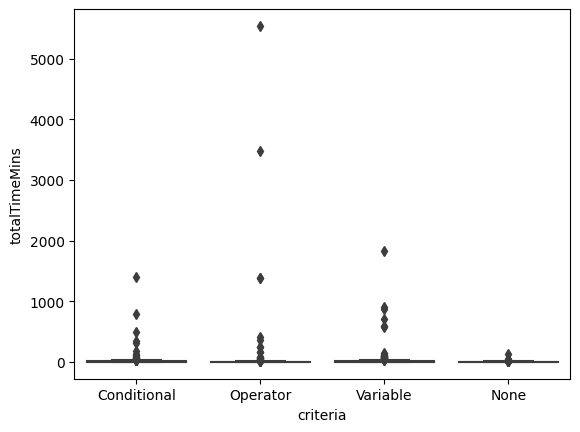

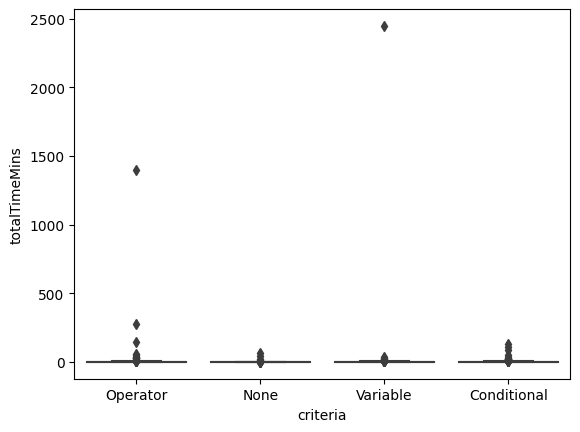

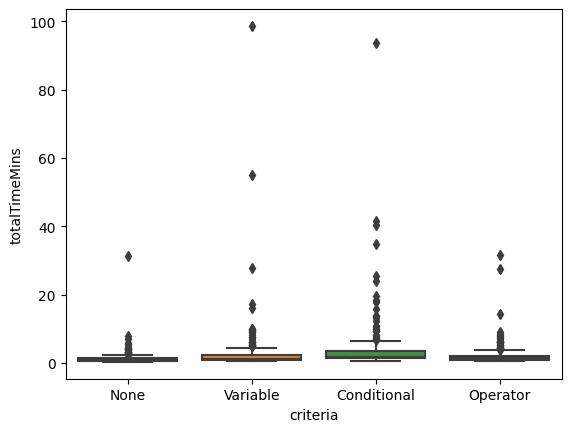

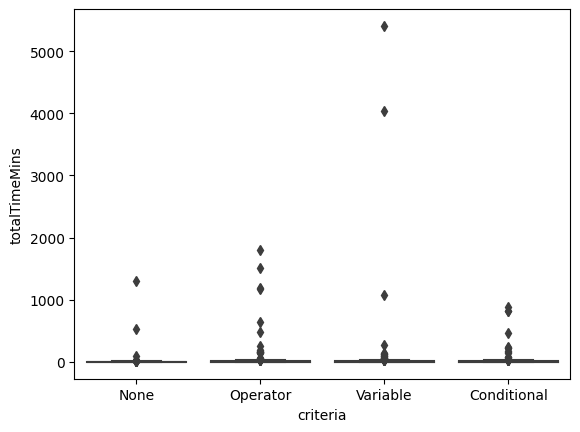

In [163]:
for i in range(4):
    sns.boxplot(df[df["problemIndex"] == i+1], y="totalTimeMins", x="criteria")
    plt.show()

## Number of Executions